# Youtube Channel Analysis

The aim of the YouTube Channel Analysis project is to provide a thorough analysis of a selected YouTube channel. In this project, I have chosen to analyze the Formula 1 (F1) official YouTube channel. By examining various metrics and visualizing the data, this project offers valuable insights into the channel's performance, audience engagement, theme identification, and keyword analysis.

The project includes the following key components:
- **Total Views, Engagement, and Number of Videos Posted per Day Plots:** This analysis calculates and presents the total views, likes, comments, and videos posted per day. The likes and comments are combined to create the Total Engagement metric, which provides an overall measure of audience involvement. Additionally, average views, videos posted, and total engagement are calculated on a quarterly basis, enabling a more comprehensive understanding of performance and its trends over time.

- **Distribution of Total Views, Likes, Comments, and Video Duration:** This analysis focuses on the distribution of key metrics. The data is filtered to enhance interpretation, and histograms are used to visualize the distribution of total views, likes, comments, and video duration. By applying appropriate filters, the plots provide a clearer representation of the data.

- **Wordcloud of the Most Common Keywords:** A wordcloud is generated to provide a basic overview of the most frequently used keywords in the video titles. Also the relationship between Views and Total Engagement is also examined.

- **Views vs Total Engagement Analysis:** In this analysis, the relationship between Views and Total Engagement is plotted, and a nonlinear regression line is fitted to determine the trend.

- **Theme Analysis:** In this section, keywords are extracted from video titles to identify common themes. Using K-means clustering, similar keywords are grouped together to form themes. This automated approach helps categorize videos based on their titles, providing a structured way to analyze content.

- **Keyword Analysis:** Based on the distribution plots, thresholds are established to define viral videos. Videos surpassing these thresholds in terms of views, likes, and comments are classified as trending. This analysis helps to identify the most popular and engaging videos on the channel and provides insights into the specific keyword combinations utilized in the titles of these videos. By examining the relationship between keywords and video performance, valuable information is obtained regarding the effective use of keywords in attracting and engaging the audience.

The project, through its analysis on key components such as audience engagement, content distribution, keyword utilization, and theme identification, offers significant benefits to channel owners and content creators. By conducting this in-depth analysis, valuable insights are gained that contribute to a better understanding of the audience, optimization of video distribution, and identification of trends that drive engagement. The YouTube Channel Analysis project builds a solid base and empowers channel owners and content creators to make informed decisions regarding content strategy and decision-making. 

**Comment:** There are explanatory hashtags above each line of code for ease of understanding and being able to follow the process better.

In [1]:
# Import libraries
import googleapiclient.discovery
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
from adjustText import adjust_text

---
***The data is obtained using the YouTube Data API v3 from Google Cloud. The code used is shown below. The code will not be executed due to limitations in quotas. Instead, the obtained data is saved into an Excel file.***

###### Enter your API key here
api_key = ****
###### Create a YouTube API client
youtube = googleapiclient.discovery.build('youtube', 'v3', developerKey=api_key)

###### Define the channel username
channel_username = "Formula1"

###### Call the channels().list() method to retrieve information about the channel
channel_response = youtube.channels().list(
    part="id",
    forUsername=channel_username
).execute()

###### Extract the channel ID from the API response
if "items" in channel_response and len(channel_response["items"]) > 0:
    channel_id = channel_response["items"][0]["id"]

###### Define the start and end dates for your data collection period
start_date = datetime.datetime(year=2021, month=1, day=1)

end_date = datetime.datetime(year=2023, month=5, day=31)

###### Define the parameters for your search query
search_params = {
    'part': 'id',
    'channelId': channel_id,
    'type': 'video',
    'maxResults': 100,
}

###### Define the parameters for your video statistics query
video_params = {
    'part': 'statistics,snippet',
    'maxResults': 100,
}

###### Create an empty list to store the video data
data = []

###### Loop over 15-day periods and retrieve all videos from each period
delta = datetime.timedelta(days=15)
while start_date <= end_date:
    # Define the start and end dates for the current period
    period_start = start_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    period_end = (start_date + delta).strftime('%Y-%m-%dT%H:%M:%SZ')
    
    # Set the publishedAfter and publishedBefore parameters for the search query
    search_params['publishedAfter'] = period_start
    search_params['publishedBefore'] = period_end
    
    # Execute the search query and collect the video IDs
    search_query = youtube.search().list(**search_params)
    search_results = search_query.execute()
    video_ids = [item['id']['videoId'] for item in search_results['items']]
    
    video_params = {
    'part': 'snippet,contentDetails,statistics', # include contentDetails here
    'id': '', # this will be updated with video IDs for each period
    'maxResults': 50
    }
    
    # Set the id parameter for the video statistics query
    video_params['id'] = ','.join(video_ids)
    
    # Execute the video statistics query and collect the data
    video_query = youtube.videos().list(**video_params)
    video_results = video_query.execute()
    for item in video_results['items']:
        title = item['snippet']['title']
        date = item['snippet']['publishedAt'][:10]
        views = int(item['statistics']['viewCount'])
        duration = item['contentDetails']['duration']
        try:
            likes = int(item['statistics']['likeCount'])
        except KeyError:
            likes = 0        
        try:
            comments = int(item['statistics']['commentCount'])
        except KeyError:
            comments = 0    
        data.append([title, date, views, duration, likes, comments])
    
    # Update the start_date for the next period
    start_date += delta

###### Convert the data to a pandas DataFrame
df = pd.DataFrame(data, columns=['Title', 'Date', 'Views', 'duration', 'Likes', 'Comments'])

###### Define a function that takes a duration string in ISO 8601 format and returns the duration in seconds
def durationToSeconds(duration):
    regex = r'^PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?$'  # Define a regular expression pattern to match the duration string
    matches = re.match(regex, duration)  # Use regular expressions to match the duration string to the pattern
    hours, minutes, seconds = [int(match) if match is not None else 0 for match in matches.groups()]  # Extract the hours, minutes, and seconds components from the duration string, converting them to integers if they exist, or defaulting to 0 if they don't
    total_seconds = (hours * 3600) + (minutes * 60) + seconds  # Calculate the total duration in seconds
    return total_seconds  # Return the total duration in seconds

###### Apply the durationToSeconds function to the 'duration' column of the DataFrame to create a new 'duration_seconds' column
df['duration_seconds'] = df['duration'].apply(durationToSeconds)


###### Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

----
## Dataset information 

In [2]:
# Selects the excell file 
df = pd.read_excel (r'C:\Users\ASpyrou\Downloads\F1_Youtube_Channel_Data.xlsx')

In [3]:
# Display the dataframe
df.head(10)

,Title,Date,Views,duration,Likes,Comments,duration_seconds
0,2020 Turkish Grand Prix: Extended Race Highlights,2021-01-04,9048675,PT18M39S,105999,2770,1119
1,Formula 2: Top 10 Moments Of 2020 Season,2021-01-05,383530,PT5M37S,12141,442,337
2,Top 10 Overtakes of the 2020 F1 Season,2021-01-06,1873636,PT5M6S,45862,1826,306
3,Top 10 Moments of Lewis Hamilton Brilliance,2021-01-07,6390882,PT17M40S,121232,5954,1060
4,Top 10 F1 Radio Goodbyes,2021-01-08,3873164,PT13M32S,102025,2302,812
5,The 10 Most Dramatic Crashes of the 2020 F1 Se...,2021-01-10,6820397,PT9M13S,108616,1824,553
6,Top 10 Battles of the 2020 F1 Season,2021-01-13,2369933,PT11M36S,48469,1352,696
7,Top 10 Animal Encounters in F1,2021-01-15,4497958,PT5M44S,110966,2095,344
8,INSIDE STORY: How Red Bull Performed a Mechani...,2021-01-15,3577156,PT8M35S,92620,2055,515
9,Top 10 Moments of Jenson Button Brilliance,2021-01-19,805966,PT10M56S,30296,1238,656


In [4]:
# Display the dataframe infomration
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Title             2299 non-null   object        
 1   Date              2299 non-null   datetime64[ns]
 2   Views             2299 non-null   int64         
 3   duration          2299 non-null   object        
 4   Likes             2299 non-null   int64         
 5   Comments          2299 non-null   int64         
 6   duration_seconds  2299 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 125.9+ KB


Displaying top 5 titles with most views

In [5]:
# Sort DataFrame by 'Views' column in descending order
df_sorted_highest = df.sort_values(by='Views', ascending=False)

# Display the top 5 videos with the most views
highest_views = df_sorted_highest.head(5)
highest_views

,Title,Date,Views,duration,Likes,Comments,duration_seconds
917,Race Highlights | 2021 Abu Dhabi Grand Prix,2021-12-12,22574038,PT8M8S,404208,33392,488
944,Top 10 Most Dramatic Moments Of The 2021 F1 Se...,2021-12-17,15948744,PT14M54S,246331,7326,894
341,Race Highlights | 2021 Azerbaijan Grand Prix,2021-06-06,14451283,PT7M20S,254142,14509,440
1088,Race Highlights | 2022 Bahrain Grand Prix,2022-03-20,11871655,PT7M19S,227503,10939,439
534,Grill The Grid 2021 Finale: Name Every F1 Worl...,2021-08-06,11688123,PT15M18S,331190,19245,918


Displaying top 5 titles with lowest views

In [6]:
# Sort DataFrame by 'Views' column in descending order
df_sorted_lowest = df.sort_values(by='Views', ascending=True)

# Display 5 videos with the lowest views
lowest_views = df_sorted_lowest.head(5)
lowest_views

,Title,Date,Views,duration,Likes,Comments,duration_seconds
1803,Chasing The Dream | Episode 5: Dutch Passion |...,2022-11-07,12313,PT14M19S,394,9,859
2258,Mario Theissen: The Highs And Lows Of BMW’s F1...,2023-05-10,16800,PT1H9M29S,634,90,4169
641,Jackie Oliver On Racing In The 1960s And Being...,2021-09-15,22168,PT1H5M11S,566,70,3911
1802,Chasing The Dream | Episode 4: Fine Margins | ...,2022-11-07,22266,PT14M31S,551,25,871
1441,Jody Egginton's Journey To F1 Tech Boss | Beyo...,2022-07-13,22696,PT1H10M59S,514,48,4259


---
## Total Views, Engagement, and Number of Videos posted per day plots

The following calculations are presented below: total views, likes, comments, and videos posted per day. In order to capture the overall level of audience engagement, the likes and comments are combined to create the Total Engagement metric. This aggregated measure provides insight into the audience's overall involvement with the videos.

Additionally, the average views, videos posted, and total engagement are calculated on a quarterly basis, allowing for a more comprehensive understanding of the performance over time.

In [7]:
# Group the data by date and apply the sum and count functions to the other columns
Grouped_data = df.groupby('Date').agg({'Views': 'sum', 'Likes': 'sum', 'Comments': 'sum', 'Date': 'count'})

# Rename the columns to be more descriptive
Grouped_data.columns = ['Total_Views', 'Total_Likes', 'Total_Comments', 'Total_Videos']

# Calculating Total Engagement
Grouped_data['Total_Engagement']= Grouped_data['Total_Likes'] + Grouped_data['Total_Comments'] 
df['Total_Engagement']= df['Likes'] + df['Comments'] 

# Format the date in the index
Grouped_data.index = Grouped_data.index.strftime('%Y-%m-%d')

# Converting the index to datetime
Grouped_data.index = pd.to_datetime(Grouped_data.index)

# Group the data by day and sum the views
df_views  = Grouped_data['Total_Views'].resample('D').sum()

# Group the data by day and count the number of videos
df_video_count  = Grouped_data['Total_Videos'].resample('D').sum()

# Group the data by day and sum the Engagement
df_engagement  = Grouped_data['Total_Engagement'].resample('D').sum()

# Calculate the average number of videos per quarter
df_video_count_qrt = df_video_count.resample('Q').mean()

# Calculate the average number of views per quarter
df_views_count_qrt = df_views.resample('Q').mean()

# Calculate the average number of engagement per quarter
df_engagement_qrt = df_engagement.resample('Q').mean()

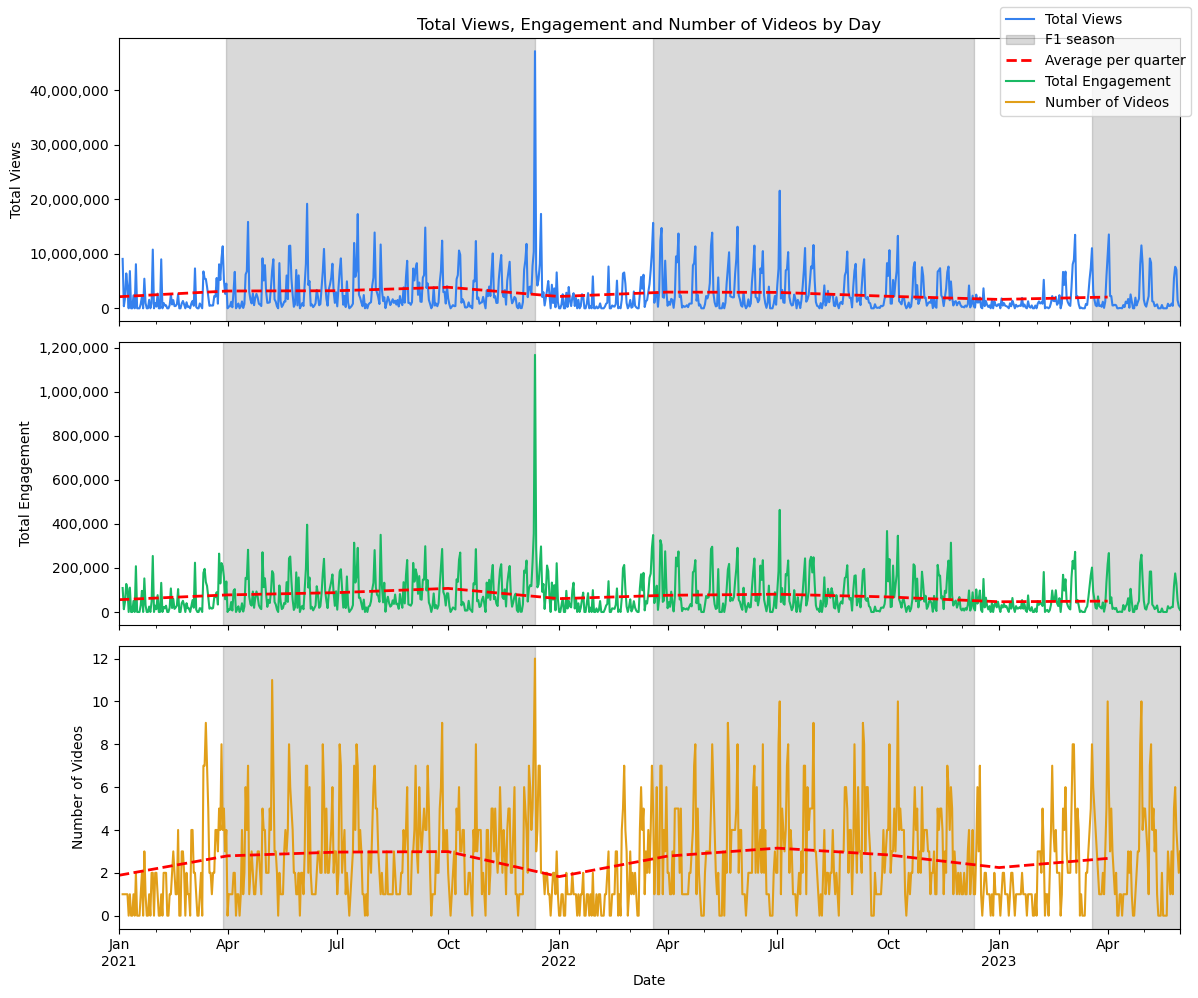

In [8]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12,10), sharex=True)

# Format x-axis values with commas
def x_axis_formatter(x, pos):
    return '{:,}'.format(int(x))

# Format y-axis values with commas
def y_axis_formatter(x, pos):
    return '{:,}'.format(int(x))

# Plot the Total Views per day on the first subplot
df_views.plot(kind='line', ax=ax1, color='#3581EE', label='Total Views')
ax1.set_ylabel('Total Views')
ax1.set_title('Total Views, Engagement and Number of Videos by Day')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(y_axis_formatter))

# Plot the Total Engagement per day on the second subplot
df_engagement.plot(kind='line', ax=ax2, color='#1AB964', label='Total Engagement')
ax2.set_ylabel('Total Engagement')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(y_axis_formatter))

# Plot the Number of Vdeos per day on the third subplot
df_video_count.plot(kind='line', ax=ax3, color='#E19F19', label='Number of Videos')
ax3.set_ylabel('Number of Videos')
ax3.set_xlabel('Date')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add bars to indicate start and finish of F1 season for each year
ax1.axvspan(pd.to_datetime('2021-03-31'), pd.to_datetime('2021-12-12'), alpha=0.15, color='#000000', label='F1 season')
ax2.axvspan(pd.to_datetime('2021-03-28'), pd.to_datetime('2021-12-12'), alpha=0.15, color='#000000')
ax3.axvspan(pd.to_datetime('2021-03-28'), pd.to_datetime('2021-12-12'), alpha=0.15, color='#000000')
ax1.axvspan(pd.to_datetime('2022-03-20'), pd.to_datetime('2022-12-11'), alpha=0.15, color='#000000')
ax2.axvspan(pd.to_datetime('2022-03-20'), pd.to_datetime('2022-12-11'), alpha=0.15, color='#000000')
ax3.axvspan(pd.to_datetime('2022-03-20'), pd.to_datetime('2022-12-11'), alpha=0.15, color='#000000')
ax1.axvspan(pd.to_datetime('2023-03-19'), pd.to_datetime('2023-12-03'), alpha=0.15, color='#000000')
ax2.axvspan(pd.to_datetime('2023-03-19'), pd.to_datetime('2023-12-03'), alpha=0.15, color='#000000')
ax3.axvspan(pd.to_datetime('2023-03-19'), pd.to_datetime('2023-12-03'), alpha=0.15, color='#000000')

# Plot the average number of videos and views per quarter as a horizontal line
df_views_count_qrt.plot(kind='line', ax=ax1, color='red', linewidth=2, linestyle='--', label='Average per quarter')
df_engagement_qrt.plot(kind='line', ax=ax2, color='red', linewidth=2, linestyle='--', label='Average per quarter')
df_video_count_qrt.plot(kind='line', ax=ax3, color='red', linewidth=2, linestyle='--', label='Average per quarter')

# Set a single legend for both subplots
handles, labels = [], []
for ax in [ax1, ax2, ax3]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
fig.legend(handles, labels)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

The plot above displays the total views, engagement, and number of videos posted per day throughout the entire dataset period. The red dotted line represents the average for each quarter, providing insights into the overall trend. Additionally, the grey area indicates the duration of the F1 seasons. Notably, the channel experiences an upsurge in the Number of Videos posted, Total Engagement, and Views during the F1 season. Towards the end of the 21-22 season, there is a noticeable spike in views and total engagement. This can be attributed to the final race of the season, where Lewis Hamilton and Max Verstappen were tied in points, and the championship was decided. Max Verstappen's last-lap overtake of Lewis Hamilton resulted in him clinching the title. This particular event generated significant interest and greatly influenced the viewership of the channel's videos during that specific period.

---
## Distribution of total views, likes, comments, and video duration 
The distributions are filtered in order to make easier interpetation of the data and avoid having 8 out of 10 bins with almost 0 data on y axis.

The filters applied are:
- Views distribution is filtered based on videos with less than 5m views
- Likes distribution is filtered based on videos with less than 100k likes
- Comments distribution is filtered based on videos with less than 7k comments
- Video duration distribution is filtered based on videos having a duration of less than 3k secconds

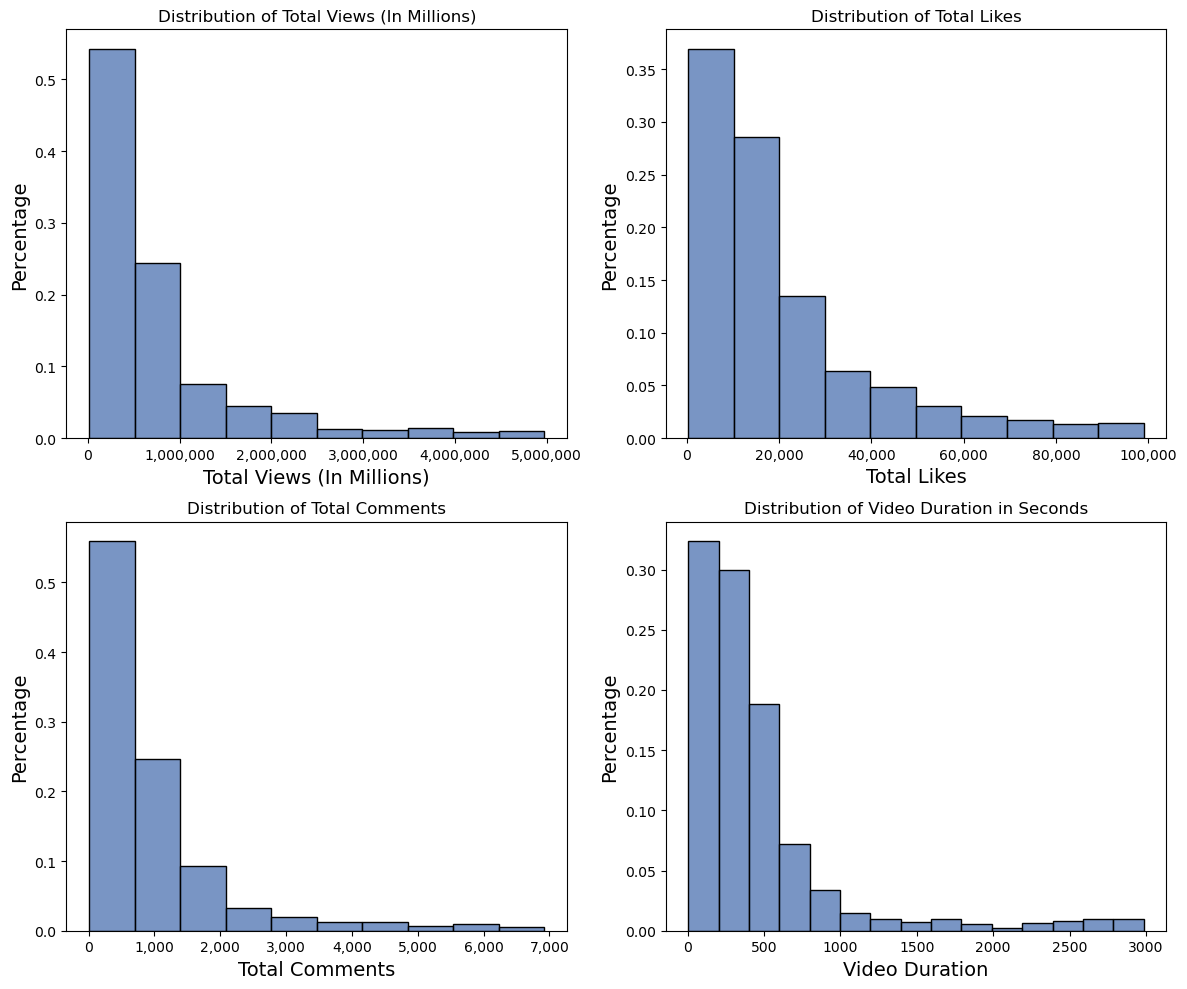

In [9]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Format the x tick labels with commas
ax.xaxis.set_major_formatter(mtick.FuncFormatter(x_axis_formatter))

# First plot: Distribution of total views in millions for videos under 5M views
plt.subplot(2, 2, 1)
ax1 = sns.histplot(df[df['Views'] < 5000000], x="Views", stat='probability', bins=10, color='#4C72B0')
plt.title("Distribution of Total Views (In Millions)")
plt.xlabel("Total Views (In Millions)", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
ax1.xaxis.set_major_formatter(mtick.FuncFormatter(x_axis_formatter))

# Second plot: Distribution of total likes in millions for videos under 1K likes
plt.subplot(2, 2, 2)
ax2 = sns.histplot(df[df['Likes'] < 100000], x="Likes", stat='probability', bins=10, color='#4C72B0')
plt.title("Distribution of Total Likes")
plt.xlabel("Total Likes", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
ax2.xaxis.set_major_formatter(mtick.FuncFormatter(x_axis_formatter))

# Third plot: Distribution of total comments for videos under 7K comments
plt.subplot(2, 2, 3)
ax3 = sns.histplot(df[df['Comments'] < 7000], x="Comments", stat='probability', bins=10, color='#4C72B0')
plt.title("Distribution of Total Comments")
plt.xlabel("Total Comments", fontsize=14)
plt.ylabel("Percentage", fontsize=14)
ax3.xaxis.set_major_formatter(mtick.FuncFormatter(x_axis_formatter))

# Fourth plot: Distribution of videos per number of seconds for videos with duration under 3K seconds
plt.subplot(2, 2, 4)
ax4 = sns.histplot(df[df["duration_seconds"] < 3000], x="duration_seconds", stat='probability', bins=15, color='#4C72B0')
plt.title("Distribution of Video Duration in Seconds")
plt.xlabel("Video Duration", fontsize=14)
plt.ylabel("Percentage", fontsize=14)

# Remove the space between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

**Analysis:**
- Among videos with less than 5M views, 80% of them have less than 1M views.
- For videos with less than 10K likes, 80% of them have less than 40K likes.
- When it comes to comments, 80% of the videos with less than 7K comments have less than 1.5K comments.
- Regarding video duration, 80% of the videos with a duration of less than 3K seconds have a duration of less than 600 seconds.

---
## Wordcloud of the Most Common Keywords

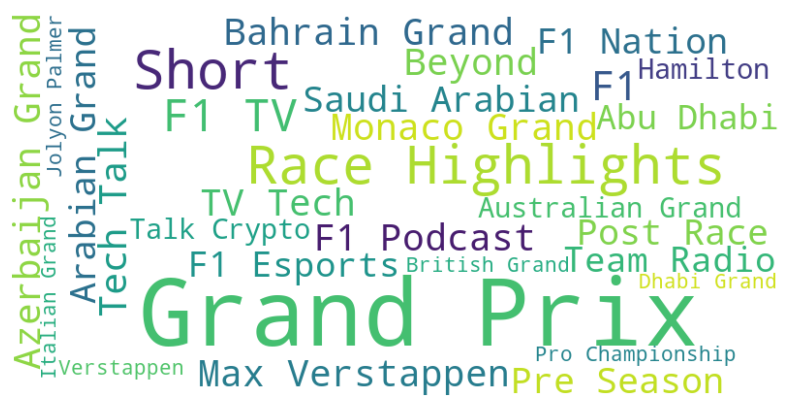

In [10]:
# Concatenate all titles into a single string
text = " ".join(title for title in df['Title'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words = 30).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The word cloud above displays the top 30 most frequently used keywords in video titles. It provides a general overview of the keywords that are commonly utilized in titles. Some notable keywords include "Grand Prix," "Short," "Race Highlights," "F1 TV," and "F1."

--- 
## Relationship of Views and Total Engagement 

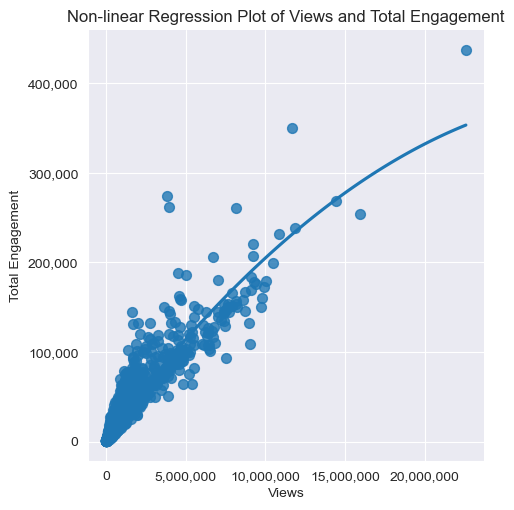

In [11]:
# Set the style and create the plot
sns.set_style('darkgrid')
ax = sns.lmplot(x='Views', y='Total_Engagement', data=df, order=2, ci=None, scatter_kws={'s': 50})
plt.title('Non-linear Regression Plot of Views and Total Engagement')

# Format the x and y tick labels with commas
ax.ax.xaxis.set_major_formatter(mtick.FuncFormatter(x_axis_formatter))
ax.ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_axis_formatter))

# Set the x and y axis labels
plt.xlabel('Views')
plt.ylabel('Total Engagement')

# Show the plot
plt.show()

The above scatter plot with a non-linear regression illustrates the relationship between views and total engagement. The plot demonstrates that higher views are associated with increased total engagement.

---
## Theme Analysis

In the part below we will extract keywords from the title column. These keywords are later used to create themes for the videos. 
All words will be converted to lowercase for consistency, non-alphanumeric words and stop words are filtered out. 

In [12]:
# Extract keywords from the title
def extract_keywords(title):
    # Set of stop words for English language
    stop_words = set(stopwords.words('english'))
    
    # Tokenize the title into words and convert them to lowercase
    words = word_tokenize(title.lower())
    
    # Filter out non-alphanumeric words and stop words
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    
    # Join the keywords into a string separated by spaces
    return " ".join(keywords)

# Applying extract_keywords function
df['Keywords'] = df['Title'].apply(extract_keywords)

Below you can see an example of keywords extracted from the first 10 titles of our dataframe.

In [13]:
# Display the first ten records from Keywords column
df['Keywords'].head(10)

0     2020 turkish grand prix extended race highlights
1                 formula 2 top 10 moments 2020 season
2                      top 10 overtakes 2020 f1 season
3             top 10 moments lewis hamilton brilliance
4                             top 10 f1 radio goodbyes
5                   10 dramatic crashes 2020 f1 season
6                        top 10 battles 2020 f1 season
7                          top 10 animal encounters f1
8    inside story red bull performed mechanical mir...
9              top 10 moments jenson button brilliance
Name: Keywords, dtype: object

The code below automates the process of generating themes for YouTube videos based on keywords extracted from their titles. 
It utilizes K-means clustering, an unsupervised machine learning algorithm, to group similar keywords together. The number of clusters,
which determines the number of themes, is specified as 25 in this case. Each theme is represented by four keywords,
automatically selected as the highest-scoring within each theme.

The code first creates a TF-IDF vectorizer, which converts the keyword text into numerical representations. 
The vectorizer is then fitted and transformed using the keyword data from the DataFrame. 
Next, K-means clustering is applied to the TF-IDF vectors, creating the specified number of themes. 

In summary, this code enables the automatic generation of themes for YouTube videos based on keyword extraction from their titles. 
The K-means clustering algorithm and TF-IDF vectorization are used to group similar keywords into themes, 
providing a structured and automated approach for categorizing videos.

In [14]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the keyword text into TF-IDF vectors
tfidf_matrix = vectorizer.fit_transform(df['Keywords'])

# Get the feature names (keywords)
feature_names = vectorizer.get_feature_names_out()

# Define the number of themes you want to create
num_themes = 25

# Perform k-means clustering on the TF-IDF vectors to create themes
kmeans = KMeans(n_clusters=num_themes, random_state=0, n_init=10).fit(tfidf_matrix)

# Assign the theme labels to each video
df['Theme'] = kmeans.labels_

# Create a dictionary to store the keywords for each theme
theme_keywords = {i: [] for i in range(num_themes)}

# Get the keywords for each theme
for i, cluster_center in enumerate(kmeans.cluster_centers_):
    sorted_keywords = [feature_names[j] for j in cluster_center.argsort()[:-5:-1]]
    theme_keywords[i] = sorted_keywords

# Print the themes and their corresponding keywords
for theme, keywords in theme_keywords.items():
    print(f"Theme {theme + 1}: {keywords}")

Theme 1: ['lap', 'good', 'great', 'vs']
Theme 2: ['shorts', 'f1', '2023', '2021']
Theme 3: ['weekend', 'prix', 'grand', '2022']
Theme 4: ['top', '10', 'moments', 'dramatic']
Theme 5: ['verstappen', 'hamilton', 'prix', 'grand']
Theme 6: ['react', 'drivers', 'qualifying', 'prix']
Theme 7: ['highlights', 'fp1', 'qualifying', 'prix']
Theme 8: ['fp3', 'highlights', 'prix', 'grand']
Theme 9: ['race', 'highlights', 'prix', 'grand']
Theme 10: ['parade', 'live', 'drivers', 'prix']
Theme 11: ['reaction', 'drivers', '2022', 'prix']
Theme 12: ['abu', 'dhabi', 'prix', 'grand']
Theme 13: ['podcast', 'f1', 'nation', 'grid']
Theme 14: ['pirelli', 'pole', 'lap', 'onboard']
Theme 15: ['live', 'show', 'f1', 'post']
Theme 16: ['fp2', 'highlights', 'prix', 'grand']
Theme 17: ['fastest', 'dhl', 'stop', 'pit']
Theme 18: ['palmer', 'jolyon', 'analysis', 'tv']
Theme 19: ['tech', 'talk', 'tv', 'f1']
Theme 20: ['best', 'radio', 'team', '2022']
Theme 21: ['arabian', 'saudi', 'prix', 'grand']
Theme 22: ['vettel', 

So now based on the themes extracted we are able to create themes and categorise each video title accordingly. The below themes and their corresponding keywords are 
derived based on the theme analysis provided above and exploration done on the titles. Overall, it is noted that these themes are present on the majority of the titles.
If a video title doesn't match a theme it will be categorized as 'Uncategorized'.

In [15]:
# Define the themes and their corresponding keywords into a dictionary
theme_keywords = {
    'Esports': ['esports'],
    'Esports Highlights': ['esports','highlights'],  
    'Practice-I': ['fp1'],
    'Practice-II': ['fp2'],    
    'Practice-III': ['fp3'],    
    'Practice Highlights-I': ['fp1','highlights'],
    'Practice Highlights-II': ['fp2','highlights'],    
    'Practice Highlights-III': ['fp3','highlights'],        
    'F1 Qualifying Highlights': ['qualifying', 'highlights'],
    'F1 Race Highlights': ['race', 'highlights'],      
    'F2 Highlights-I': ['f2','highlights'],  
    'F2 Highlights-II': ['formula', '2', 'highlights'],     
    'F3 Highlights-I': ['f3', 'highlights'],
    'F3 Highlights-II': ['formula', '3', 'highlights'],  
    'Testing': ['testing'],      
    'Live': ['live'], 
    'Team Radio': ['radio'],
    'Podcast': ['podcast'],
    'Top-10': ['top', '10'],
    'Top-5': ['top','5'],    
    'Pole lap': ['pole', 'lap' ,'pirelli'],
    'TV Tech Talk': ['tv', 'tech' ,'talk'],
    'TV Analysis': ['tv', 'analysis','jolyon' ,'palmer'],
    'Drivers Reaction': ['drivers', 'reaction'],   
    '#Shorts': ['shorts'],  
    'Fastest Pit Stop': ['fastest', 'pit', 'stop', 'dhl'],     
}

# Function to find the theme based on keywords
def find_theme(keywords):
    for theme, theme_keywords_list in theme_keywords.items():
        if all(keyword in keywords for keyword in theme_keywords_list):
            return theme
    return 'Uncategorized'

# Categorize each list of keywords into a theme
df['Theme'] = df['Keywords'].apply(find_theme)

df.head(10)

,Title,Date,Views,duration,Likes,Comments,duration_seconds,Total_Engagement,Keywords,Theme
0,2020 Turkish Grand Prix: Extended Race Highlights,2021-01-04,9048675,PT18M39S,105999,2770,1119,108769,2020 turkish grand prix extended race highlights,F1 Race Highlights
1,Formula 2: Top 10 Moments Of 2020 Season,2021-01-05,383530,PT5M37S,12141,442,337,12583,formula 2 top 10 moments 2020 season,Top-10
2,Top 10 Overtakes of the 2020 F1 Season,2021-01-06,1873636,PT5M6S,45862,1826,306,47688,top 10 overtakes 2020 f1 season,Top-10
3,Top 10 Moments of Lewis Hamilton Brilliance,2021-01-07,6390882,PT17M40S,121232,5954,1060,127186,top 10 moments lewis hamilton brilliance,Top-10
4,Top 10 F1 Radio Goodbyes,2021-01-08,3873164,PT13M32S,102025,2302,812,104327,top 10 f1 radio goodbyes,Team Radio
5,The 10 Most Dramatic Crashes of the 2020 F1 Se...,2021-01-10,6820397,PT9M13S,108616,1824,553,110440,10 dramatic crashes 2020 f1 season,Uncategorized
6,Top 10 Battles of the 2020 F1 Season,2021-01-13,2369933,PT11M36S,48469,1352,696,49821,top 10 battles 2020 f1 season,Top-10
7,Top 10 Animal Encounters in F1,2021-01-15,4497958,PT5M44S,110966,2095,344,113061,top 10 animal encounters f1,Top-10
8,INSIDE STORY: How Red Bull Performed a Mechani...,2021-01-15,3577156,PT8M35S,92620,2055,515,94675,inside story red bull performed mechanical mir...,Uncategorized
9,Top 10 Moments of Jenson Button Brilliance,2021-01-19,805966,PT10M56S,30296,1238,656,31534,top 10 moments jenson button brilliance,Top-10


Now lets see how many videos are under each theme.

In [16]:
# Count the keywords per theme
theme_counts = df['Theme'].value_counts()
theme_counts

Uncategorized               866
#Shorts                     216
F1 Race Highlights          167
Podcast                     147
Team Radio                  126
Top-10                      101
Live                         83
TV Tech Talk                 77
Esports                      64
Drivers Reaction             61
Practice-II                  53
Testing                      53
Practice-I                   53
F1 Qualifying Highlights     50
TV Analysis                  46
Pole lap                     44
Practice-III                 42
Top-5                        35
Fastest Pit Stop             15
Name: Theme, dtype: int64

After observing the uncategorized videos, our next step is to search for additional themes based on the uncategorized titles and update the theme keywords accordingly.
We will count the frequency of each keyword in the uncategorized titles and analyze the results to uncover any valuable insights.

In [17]:
# Count the keywords without a theme
themed_keywords = df[df['Theme'] == 'Uncategorized']['Keywords']

# Join and split the keywords to form a list of words
all_themed_keywords = ' '.join(themed_keywords).split()  
themed_keyword_counter = Counter(all_themed_keywords)

# Create a new DataFrame with the keywords and counts sorted largest to smallest
themed_keyword_counts_df = pd.DataFrame.from_dict(themed_keyword_counter, orient='index', columns=['Count']).reset_index()
themed_keyword_counts_df.columns = ['Keyword', 'Count']
themed_keyword_counts_df = themed_keyword_counts_df.sort_values(by='Count', ascending=False)
themed_keyword_counts_df.head(40)

,Keyword,Count
47,grand,453
48,prix,453
44,2021,243
4,f1,243
443,2022,221
104,lap,111
868,2023,110
16,drivers,91
203,verstappen,80
62,hamilton,58


Based on the printed keywords above, we can observe that the keyword "react" is not categorized. It should be added to the "Drivers-Reaction".
Additionally, let's print the count of titles along with their corresponding keywords that contain the words "lap" and "best". This will help us determine if there is a significant number of titles associated with these keywords.


In [18]:
# Count the number of records that contain the word "lap"
lap_count = themed_keywords[themed_keywords.str.contains('lap', case=False)].shape[0]
lap_count

84

In [19]:
# Print the lists of keywords that contain the word "lap"
filtered_lap_keywords = themed_keywords[themed_keywords.str.contains('lap', case=False)]
print(filtered_lap_keywords.to_string(index=False))

antonio giovinazzi owning lap 1 2020 seven minu...
good lap vs great lap sergio perez bahrain gran...
seconds zhou vs lundgaard f2 pole lap 2021 bahr...
awesome last lap formula 2 battle 2021 bahrain ...
good lap great lap pierre gasly emilia romagna ...
good lap great lap charles leclerc portuguese g...
nose cam flying lap portimao 2021 portuguese gr...
good lap great lap sergio perez spanish grand prix
max verstappen fastest lap 2021 spanish grand p...
good lap vs great lap lewis hamilton monaco gra...
lewis hamilton potentially vital fastest lap 20...
  good lap vs great lap 2021 azerbaijan grand prix
opening lap chaos paul ricard angles 2018 frenc...
good lap vs great lap valtteri bottas french gr...
good lap great lap lando norris styrian grand prix
good lap vs great lap daniel ricciardo british ...
lewis hamilton p1 lap qualifying 2021 british g...
good lap great lap george russell hungarian gra...
good lap vs great lap daniel ricciardo belgian ...
george russell mega q3 lap 2021

In [20]:
# Count the number of records that contain the word "best"
best_count = themed_keywords[themed_keywords.str.contains('best', case=False)].shape[0]
best_count

43

In [21]:
# Print the lists of keywords that contain the work "best"
themed_keywords[themed_keywords.str.contains('best', case=False)]

200     super starts big scrapes best onboards 2021 em...
235     mercedes red bull battle best onboards 2021 po...
271     hamilton verstappen battle best onboards 2021 ...
315     leclerc q3 crash close encounters best onboard...
351     max crash duels best onboards 2021 azerbaijan ...
390     arthur leclerc first win double overtakes best...
391     verstappen hamilton duel best onboards 2021 fr...
412     flying starts dazzling overtakes best onboards...
438     epic duels wheel wheel action best onboards 20...
485     max lewis crash speedy moves best onboards 202...
527     turn 1 chaos pit lane drama best onboards 2021...
548              best moments teamwork 2021 f1 season far
555     max dance moves kimi favourite team mate best ...
601                 valtteri bottas best moments mercedes
609                            alex albon best moments f1
686     phenomenal piastri swimming sochi best f2 mome...
823                           guanyu zhou best f2 moments
979           

As it can be seen from the above, we can also add two additional themes to our dictionary: "Good Vs Great Lap" which appears in many of the video titles that contain the word "lap" and "Best of" which has 43 videos. 
These themes could not be derived earlier due to a limited number of observations, but it is still beneficial to identify and include them 
since the channel posts videos related to these themes.

In [22]:
# Updating the themes dictionary
updated_theme_keywords = {
    'Esports-I': ['esports'],
    'Esports-II': ['virtual'],
    'Esports Highlights-I': ['esports','highlights'],
    'Esports Highlights-II': ['virtual','highlights'],  
    'Practice-I': ['fp1'],
    'Practice-II': ['fp2'],    
    'Practice-III': ['fp3'],    
    'Practice Highlights-I': ['fp1','highlights'],
    'Practice Highlights-II': ['fp2','highlights'],    
    'Practice Highlights-III': ['fp3','highlights'],   
    'F2 Highlights-I': ['f2','highlights'],  
    'F2 Highlights-II': ['formula', '2', 'highlights'],     
    'F3 Highlights-I': ['f3', 'highlights'],
    'F3 Highlights-II': ['formula', '3', 'highlights'],       
    'F1 Qualifying Highlights': ['qualifying', 'highlights'],
    'F1 Race Highlights': ['race', 'highlights'],      
    'Testing': ['testing'],      
    'Live': ['live'], 
    'Team Radio': ['radio'],
    'Podcast': ['podcast'],
    'Top-10': ['top', '10'],
    'Top-5': ['top','5'],    
    'Pole lap': ['pole', 'lap' ,'pirelli'],
    'TV Tech Talk': ['tv', 'tech' ,'talk'],
    'TV Analysis': ['tv', 'analysis','jolyon' ,'palmer'],
    'Drivers Reaction-I': ['drivers', 'reaction'],  
    '#Shorts': ['shorts'],  
    'Fastest Pit Stop': ['fastest', 'pit', 'stop', 'dhl'],   
    'Good Vs Great Lap': ['good', 'lap', 'great', 'lap'], # New theme  
    'Best of': ['best'], # New theme
    'Drivers Reaction-II': ['drivers', 'react'] # New theme
}

# Function to find the theme based on keywords
def find_theme(keywords):
    for theme, theme_keywords_list in updated_theme_keywords.items():
        if all(keyword in keywords for keyword in theme_keywords_list):
            return theme
    return 'Uncategorized'

# Categorize each list of keywords into a theme
df['Theme'] = df['Keywords'].apply(find_theme)

And below we can now see the final picture of the themed videos where we are able to categorise 69% of the titles since 31% are under the "Uncategorised" theme.   

In [23]:
# Count the keywords per theme
theme_countsI = df['Theme'].value_counts()

# Calculate the percentage for each theme
theme_percentages = (theme_countsI / len(df)) * 100

# Combine the counts and percentages into a DataFrame
theme_counts_df = pd.DataFrame({'Count': theme_countsI, 'Percentage': theme_percentages})

# Sort the DataFrame by theme count in descending order
theme_counts_df = theme_counts_df.sort_values(by='Count', ascending=False)

# Display the "theme_counts_df" dataframe
theme_counts_df

,Count,Percentage
Uncategorized,734,31.926925
#Shorts,216,9.395389
Podcast,147,6.394084
Team Radio,126,5.480644
Top-10,101,4.393214
Live,83,3.610265
TV Tech Talk,77,3.349282
Esports-I,64,2.783819
F1 Race Highlights,64,2.783819
Drivers Reaction-I,61,2.653328


We should now categorise the same themes with multiple numbers into one final theme as seen below


In [24]:
# Defining the dictionary with the grouped themes
grouped_themes = {
    'Practice': ['Practice-I', 'Practice-II', 'Practice-III'],
    'Practice Highlights': ['Practice Highlights-I', 'Practice Highlights-II', 'Practice Highlights-III'],
    'F2 Highlights': ['F2 Highlights-I', 'F2 Highlights-II'],
    'F3 Highlights': ['F3 Highlights-I', 'F3 Highlights-II'],
    'Drivers Reaction': ['Drivers Reaction-I', 'Drivers Reaction-II'],
    'Esports': ['Esports-I', 'Esports-II'],
    'Esports Highlights': ['Esports Highlights-I', 'Esports Highlights-II'],    
}

# Function to check if a theme is present in any grouped theme list
def get_new_theme_name(theme):
    for grouped_theme, themes in grouped_themes.items():
        if theme in themes:
            return grouped_theme
    return theme

# Create a new column with updated theme names
df['Final Theme'] = df['Theme'].apply(lambda x: get_new_theme_name(x))

We will now excluded the uncategorized videos, allowing us to plot a boxplot for the remaining categories. This boxplot provides an opportunity to observe and analyze the distribution of data across these categories, enabling us to gain further insights.

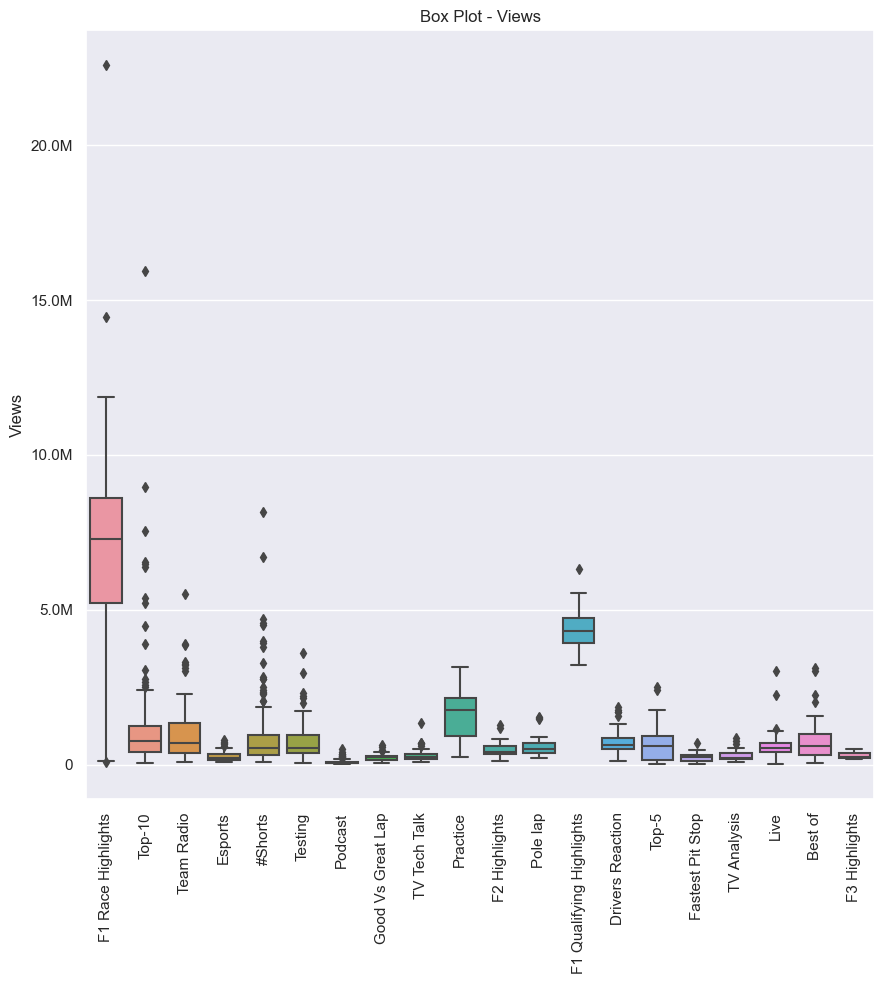

In [25]:
# Exclude the "Uncategorized" category
df_exlude_uncategorised = df[~df['Final Theme'].str.contains('Uncategorized')]

# Set the grid style
sns.set(style="darkgrid")

# Format y-axis values in millions (M) and thousands (K)
def y_axis_formatter_letters(x, pos):
    if x >= 1e6:
        value = '{:,.1f}M'.format(x * 1e-6)
    elif x >= 1e3:
        value = '{:,.0f}K'.format(x * 1e-3)
    else:
        value = '{:,.0f}'.format(x)
    return value

# Box plot for Views
fig, ax = plt.subplots(figsize=(9, 10))
sns.boxplot(x='Final Theme', y='Views', data=df_exlude_uncategorised)
ax.set_title('Box Plot - Views')
ax.set_xlabel('')
ax.set_ylabel('Views')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_axis_formatter_letters))  # Apply formatter to y-axis labels
ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels
plt.tight_layout()
plt.show()

**Analysis:**
- Views for F1 Race Highlights and F1 Qualifying Highlights are significantly higher than the other categories.
- Views under the F1 Qualifying Highlights category start at approximately 3M, making it the category with the highest starting point across all categories.
- The categories with 75% of their videos having more than 1M views are F1 Race Highlights, F1 Qualifying Highlights, and Practice.

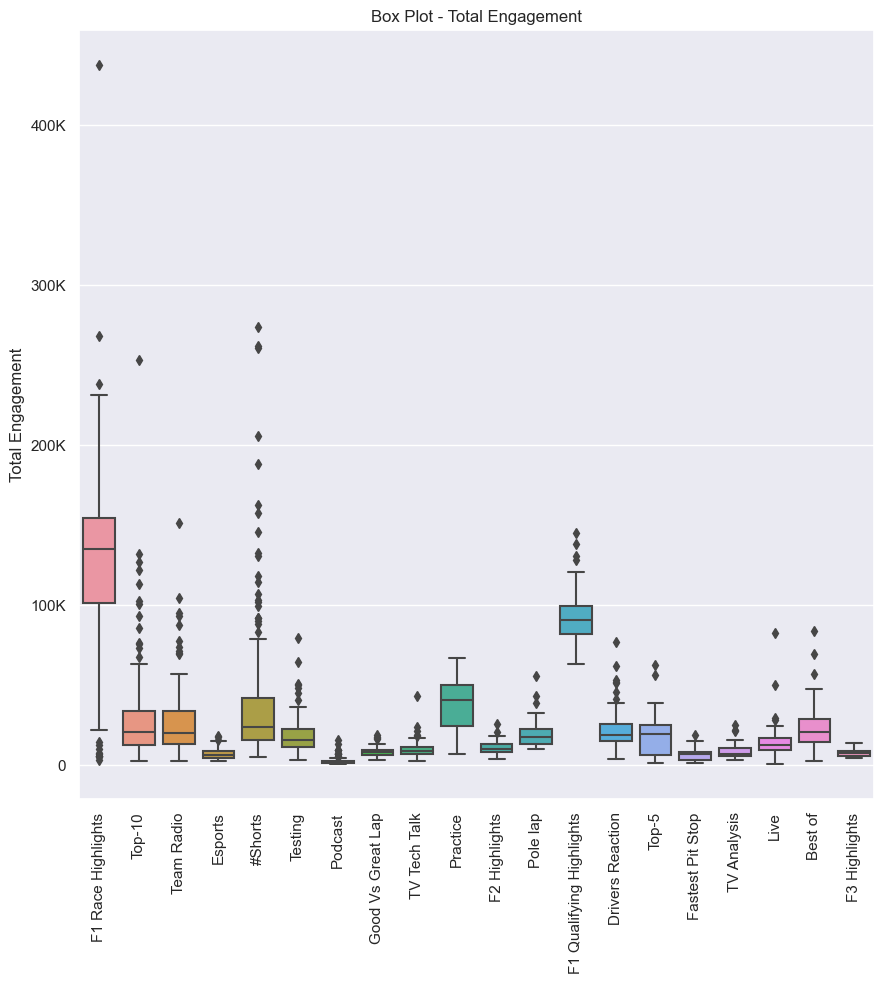

In [26]:
# Box plot for Total Engagement
fig, ax = plt.subplots(figsize=(9, 10))
sns.boxplot(x='Final Theme', y='Total_Engagement', data=df_exlude_uncategorised)
ax.set_title('Box Plot - Total Engagement')
ax.set_xlabel('')
ax.set_ylabel('Total Engagement')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_axis_formatter_letters))  # Apply formatter to y-axis labels
ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels
plt.tight_layout()
plt.show()

**Analysis:**
- Total engagement for F1 Race Highlights and F1 Qualifying Highlights is significantly higher than the other categories.
- The total engagement for each video under F1 Qualifying Highlights starts at approximately 60K and above, which is the highest starting point across all categories. This indicates that posting videos under that specific category has a high likelihood of achieving more than 60K in total engagement.
- The Podcast category appears to have the lowest ranges of total engagement.

Below we will generate barplots comparing the total views and total engagement with the number of videos per category. The uncategorized category will be excluded from the plots. This analysis will allow us to identify the categories that perform the best in terms of views and engagement. Additionally, we can determine the categories that generate higher engagement with fewer videos, helping us identify themes where more videos could be posted and themes that require fewer videos.

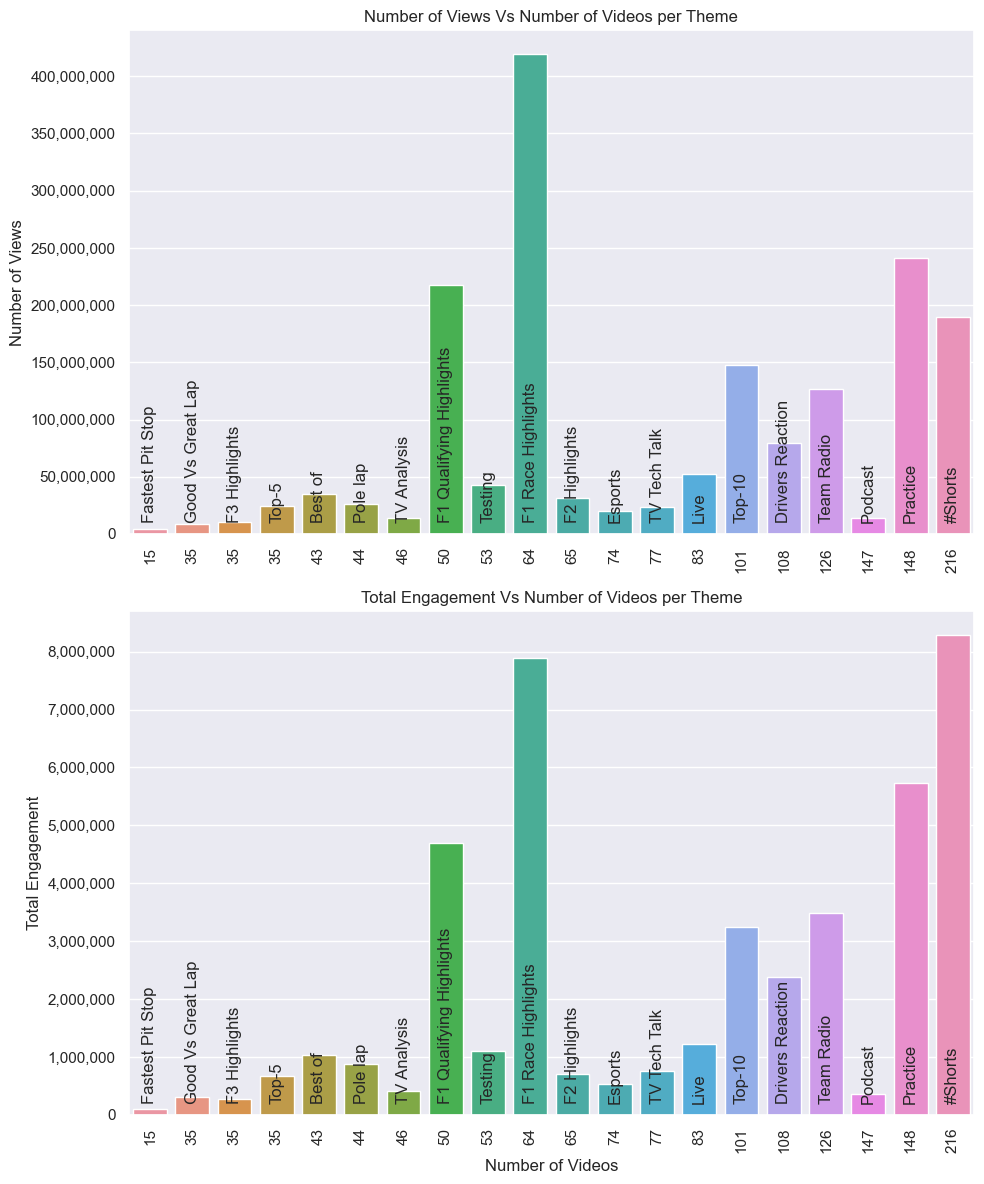

In [27]:
# Calculate the total engagement, and videos per category
df_views_cat = df_exlude_uncategorised.groupby('Final Theme').agg({'Views': 'sum', 'Title': 'count'}).reset_index()
df_tot_engagement_cat = df_exlude_uncategorised.groupby('Final Theme').agg({'Total_Engagement': 'sum', 'Title': 'count'}).reset_index()

# Rename the df_views_cat names
df_views_cat = df_views_cat.rename(columns={'Title': 'Total Videos'})
df_tot_engagement_cat = df_tot_engagement_cat.rename(columns={'Title': 'Total Videos'})

# Sort the DataFrames by "Total Videos"
df_views_sorted = df_views_cat.sort_values("Total Videos").reset_index(drop=True)
df_tot_engagement_cat = df_tot_engagement_cat.sort_values("Total Videos").reset_index(drop=True)

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot Views Vs Number of Videos
sns.barplot(x="Final Theme", y="Views", data=df_views_sorted, ax=axs[0])
axs[0].set_title("Number of Views Vs Number of Videos per Theme")
axs[0].set_xlabel("")
axs[0].set_ylabel("Number of Views")
axs[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: "{:,.0f}".format(x)))
axs[0].set_xticklabels(df_views_sorted["Total Videos"], rotation='vertical')
for i, p in enumerate(axs[0].patches):
    axs[0].annotate(df_views_sorted["Final Theme"].values[i],
                (p.get_x() + p.get_width() / 2., 0),  # Set y-coordinate to 0
                ha='center',
                xytext=(0, 10), textcoords='offset points',
                rotation='vertical')  # Rotate the text vertically
    
# Plot Total_Engagement Vs Number of Videos
sns.barplot(x="Final Theme", y="Total_Engagement", data=df_tot_engagement_cat, ax=axs[1])
axs[1].set_title("Total Engagement Vs Number of Videos per Theme")
axs[1].set_xlabel("Number of Videos")
axs[1].set_ylabel("Total Engagement")
axs[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: "{:,.0f}".format(x)))
axs[1].set_xticklabels(df_tot_engagement_cat["Total Videos"], rotation='vertical')
for i, p in enumerate(axs[1].patches):
    axs[1].annotate(df_tot_engagement_cat["Final Theme"].values[i],
                (p.get_x() + p.get_width() / 2., 0),  # Set y-coordinate to 0
                ha='center',
                xytext=(0, 10), textcoords='offset points',
                rotation='vertical')  # Rotate the text vertically
    
# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

**Analysis:**
- Based on the plots above we can clearly see that the category of "F1 Race highligts" has the most views and is second in total engagements despite being in the middle in terms of videos posted. 
- The "#Shorts" category exhibits the highest total engagement and also has a larger number of posted videos. This category leverages the new YouTube feature, which allows videos with a maximum duration of 60 seconds. To further enhance the potential of both engagement and views, short highlights can be integrated, in order to merge the strengths of these two categories. 
- Videos categorized under "Best of" and "Testing" appear to surpass those classified under "F2 Highlights," "Esports," and "TV Tech Talk" in terms of both total views and total engagement. Additionally, there are fewer videos within these categories compared to the latter ones. Consequently, increasing the number of videos under the "Best of" and "Testing" categories could potentially benefit the channel.

---
## Keyword Analysis

Let's proceed by establishing the criteria for defining a viral video based on the number of views, likes, and comments. These thresholds can be determined from the distribution plots shown earlier. Videos surpassing these thresholds in terms of views, likes, and comments will be classified as trending videos.

The threshold logic is:
- The views threshold is set at 1,000,000 since approximately 75% of the videos have fewer views than this value.
- The likes threshold is set at 10,000.
- The comments threshold is set at 500.

The likes and comments thresholds are set at relatively lower standards. This decision is based on the consideration that if we were to select thresholds that only the top 35% of videos could meet in terms of likes and comments, the number of videos satisfying all three thresholds would significantly decrease. Consequently, the available data for decision-making would be substantially reduced. By establishing a "strict" threshold solely for the number of views while maintaining reasonably good thresholds for comments and likes, we are able to include a larger number of videos in the trending category while also keeping high standards.

In [28]:
# Define the thresholds for views, likes, comments to determine a trend
views_threshold = 1000000
likes_threshold = 10000
comments_threshold = 500

# Create a new column indicating whether the video surpasses the threshold and is considered a trend
df['Trend'] = np.where((df['Views'] > views_threshold) & (df['Likes'] > likes_threshold) & (df['Comments'] > comments_threshold), 1, 0)

# Create a new dataframe with unique keywords and their counts
keywords_df = df['Keywords'].str.split(' ', expand=True).stack().value_counts().reset_index()
keywords_df.columns = ['Keyword', 'Count']

We can now determine the frequency of each keyword's inclusion in trending videos, as well as the combinations of any two keywords. This analysis enables us to identify the keywords and their combinations that are most closely associated with trending videos. Consequently, we can utilize this information in future video titles to enhance their potential for success.

In [29]:
# Creating an empty dataframe
keyword_counts_filtered = pd.DataFrame(columns=['Keyword'])

# Filtering the keyword_counts DataFrame based on the condition
filtered_keywords = keywords_df.loc[keywords_df["Count"] > 9, "Keyword"]

# Assigning the filtered keywords to the "Keyword" column of keyword_counts_filtered
keyword_counts_filtered['Keyword'] = filtered_keywords
keyword_counts_filtered.reset_index(drop=True, inplace=True)

# Creating an empty dataframe
keyword_combinations = pd.DataFrame(columns=['Keyword1', 'Keyword2', 'Trending', 'Not_Trending'])

# Iterate over each keyword in the filtered keyword_counts DataFrame
for i in range(len(keyword_counts_filtered)):
    keyword1 = keyword_counts_filtered.loc[i, 'Keyword']
    
    # Count the occurrences of 0 and 1 in the 'Trend' column for the current keyword
    count_0_1 = df[df['Keywords'].apply(lambda x: keyword1 in x.split())]['Trend'].value_counts()
    count_0 = count_0_1.get(0, 0)
    count_1 = count_0_1.get(1, 0)
    
    # Append the counts to the keyword_combinations DataFrame
    keyword_combinations = pd.concat([keyword_combinations, pd.DataFrame({'Keyword1': keyword1, 'Keyword2': '', 'Not_Trending': count_0, 'Trending': count_1}, index=[0])], ignore_index=True)

    # Iterate over the remaining keywords in the filtered keyword_counts DataFrame
    for j in range(i + 1, len(keyword_counts_filtered)):
        keyword2 = keyword_counts_filtered.loc[j, 'Keyword']
        
        # Count the occurrences of 0 and 1 in the 'Trend' column for the combination of current keyword1 and keyword2
        count_0 = df[df['Keywords'].apply(lambda x: keyword1 in x.split() and keyword2 in x.split())]['Trend'].value_counts().get(0, 0)
        count_1 = df[df['Keywords'].apply(lambda x: keyword1 in x.split() and keyword2 in x.split())]['Trend'].value_counts().get(1, 0)
        
        # Append the counts to the keyword_combinations DataFrame
        keyword_combinations = pd.concat([keyword_combinations, pd.DataFrame({'Keyword1': keyword1, 'Keyword2': keyword2, 'Not_Trending': count_0, 'Trending': count_1}, index=[0])], ignore_index=True)

# Calculation for total keyword appearances 
keyword_combinations['Keyword_Used_Count'] =  keyword_combinations['Trending'] + keyword_combinations['Not_Trending'] 

# Filtering the keyword_counts DataFrame based on the condition
keyword_combinations = keyword_combinations.loc[keyword_combinations["Keyword_Used_Count"] > 0]

# Calculation for the percentage of trending appearances
keyword_combinations['Trending%'] =  keyword_combinations['Trending'] / keyword_combinations['Keyword_Used_Count'] 

# Filtering the keyword_combinations DataFrame based on the condition
filtered_combinations = keyword_combinations.loc[(keyword_combinations["Keyword_Used_Count"] > 14) & (keyword_combinations["Trending%"] >= 0.5)]

# Sorting largest to smallest
filtered_combinations = filtered_combinations.sort_values(by='Trending%', ascending=False)

# Displaying the keyword combinations appearing in more than 14 titles and are trending in 50% of them 
filtered_combinations

,Keyword1,Keyword2,Trending,Not_Trending,Keyword_Used_Count,Trending%
1201,highlights,qualifying,50,0,50,1.0
1254,highlights,fp1,49,1,50,0.98
1019,2022,fp1,21,1,22,0.954545
14214,fp1,,49,4,53,0.924528
69,grand,fp1,49,4,53,0.924528
308,prix,fp1,49,4,53,0.924528
783,2021,fp1,22,2,24,0.916667
1253,highlights,fp2,43,6,49,0.877551
1018,2022,fp2,19,3,22,0.863636
782,2021,fp2,19,3,22,0.863636


The table displayed above illustrates the following:
- Combinations of keywords categorized under "Keyword1" and "Keyword2".
- Within the "Trending" column, it presents the number of videos that are currently trending and contain both of these keywords in their titles.
- The "Not_Trending" column showcases the count of videos that are not trending but contain the specified keyword combination in their titles. 
- The "Keyword_Used_Count" field indicates the overall number of videos in which the specific keyword combination was utilized, including both "Trending" and "Not_Trending" categories.
- The "Trending%" column represents the percentage of trending videos that employ the given keyword combination, it is calculated by the follwing formula "Trending" / "Keyword_Used_Count".

Additionally, a scatter plot comparing the trending percentage and the frequency of keyword usage will be plotted below for easier data interpretation. In order to avoid clutter and easily identify keyword combinations with the highest trending percentages, labels will be displayed only for keyword combinations that appear in more than 70 videos or have a trending percentage higher than 70%.

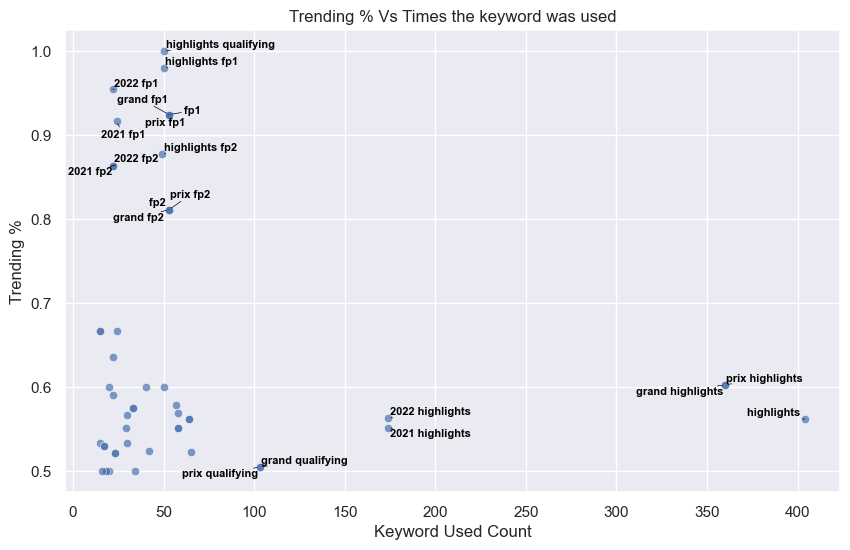

In [30]:
# Plotting the scatter chart
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Keyword_Used_Count",
    y="Trending%",
    sizes=(100, 100),  # Adjust the dot size
    data=filtered_combinations,
    alpha=0.7,
    legend=False
)

# Add labels above each dot
labels = []
for i in range(len(filtered_combinations)):
    x = filtered_combinations['Keyword_Used_Count'].iloc[i]
    y = filtered_combinations['Trending%'].iloc[i]
    
    if y >= 0.7 or x >= 70:
        label = filtered_combinations['Keyword1'].iloc[i] + ' ' + filtered_combinations['Keyword2'].iloc[i]
        labels.append(plt.text(
            x,
            y,
            label,
            ha='center',
            fontsize=8,
            fontweight='bold',
            color='black'
        ))
        
# Adjust the position of labels to minimize overlap
adjust_text(labels, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# Setting labels and title
plt.xlabel("Keyword Used Count")
plt.ylabel("Trending %")
plt.title("Trending % Vs Times the keyword was used")

# Display the plot
plt.show()

**Analysis:**
- Based on the above results, we can observe that the keyword "highlights" prominently appears in several of the top trending keyword combinations.
- The keywords "fp1" and "fp2," which refer to practice sessions, also feature among the popular trending keyword combinations.
- Notably, videos focusing on the highlights of Grand Prix races in Monaco, Abu Dhabi, Saudi Arabia, and Azerbaijan exhibit significant success, as the keyword combination of "highlights" along with the specific race names results in a 60% occurrence rate among trending videos as seen in the table ploted above the chart.